# 🧪 Notebook 09: Hyperparameter Tuning

**Autor:** Gian  
**Fecha:** 2026-01-19  
**Objetivo:** Optimizar el modelo seleccionado (Random Forest) mediante búsqueda de hiperparámetros (GridSearchCV) para maximizar el área bajo la curva curva ROC (AUC).

---

## 📋 Contenido

1. Configuración del entorno
2. Carga de datos
3. Configuración de GridSearchCV
4. Ejecución de la Búsqueda
5. Evaluación del Mejor Modelo
6. Guardado del Modelo Final

---
## 1. Configuración del Entorno

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import joblib

# Modelado
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")

np.random.seed(42)

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


---
## 2. Carga de Datos
Usamos nuevamente `07_data_selected.csv` y mantenemos el mismo seed para el split.

In [8]:
# Rutas
OUTPUT_PATH = Path("../../outputs/gian")
DATA_PATH = OUTPUT_PATH / "data" / "07_data_selected.csv"
MODELS_PATH = OUTPUT_PATH / "models"
MODELS_PATH.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(DATA_PATH)

X = df.drop(columns=['cancelacion', 'cliente_id'])
y = df['cancelacion']

# Split (Mismo random_state que nb 08)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"📊 Training Set: {X_train.shape[0]} muestras")

📊 Training Set: 7760 muestras


---
## 3. Configuración de GridSearchCV
Definimos la grilla de hiperparámetros para Random Forest.

**Parámetros a explorar:**
*   `n_estimators`: Número de árboles.
*   `max_depth`: Profundidad máxima (control de complejidad).
*   `min_samples_leaf`: Mínimas muestras en nodo final (regularización).
*   `class_weight`: None vs 'balanced' (manejo de desbalance).

In [9]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

# Modelo base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Configurar GridSearch
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                 # 5-Fold Cross Validation
    scoring='roc_auc',    # Métrica principal
    n_jobs=-1,            # Usar todos los núcleos
    verbose=2
)

---
## 4. Ejecución de la Búsqueda
Entrenamos el GridSearch. Esto puede tardar unos minutos.

In [10]:
print("🚀 Iniciando Hyperparameter Tuning... por favor espere.")
grid_search.fit(X_train, y_train)

print("\n✅ Búsqueda completada.")
print(f"🏆 Mejores Hiperparámetros: {grid_search.best_params_}")
print(f"⭐️ Mejor ROC-AUC (CV): {grid_search.best_score_:.4f}")

🚀 Iniciando Hyperparameter Tuning... por favor espere.
Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END class_weight=None, max_depth=None, min_samples_leaf=1, n_estimators=100; total time=   1.1s
[CV] END class_weight=None, max_depth=None, min_samples_leaf=1, n_estimators=100; total time=   1.3s
[CV] END class_weight=None, max_depth=None, min_samples_leaf=1, n_estimators=100; total time=   1.4s
[CV] END class_weight=None, max_depth=None, min_samples_leaf=1, n_estimators=100; total time=   1.7s
[CV] END class_weight=None, max_depth=None, min_samples_leaf=1, n_estimators=100; total time=   1.7s
[CV] END class_weight=None, max_depth=None, min_samples_leaf=1, n_estimators=200; total time=   3.0s
[CV] END class_weight=None, max_depth=None, min_samples_leaf=1, n_estimators=200; total time=   3.3s
[CV] END class_weight=None, max_depth=None, min_samples_leaf=1, n_estimators=200; total time=   3.5s
[CV] END class_weight=None, max_depth=None, min_samples_leaf=1, n_estimator

---
## 5. Evaluación del Mejor Modelo
Evaluamos el modelo optimizado en el conjunto de prueba (Test Set).

📊 Reporte de Clasificación (Test Set):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1636
           1       0.84      0.85      0.84       305

    accuracy                           0.95      1941
   macro avg       0.91      0.91      0.91      1941
weighted avg       0.95      0.95      0.95      1941

🚀 ROC-AUC Final en Test: 0.9302
📊 Gráfico guardado en: ../../outputs/gian/figures/09_confusion_matrix_best_model.png


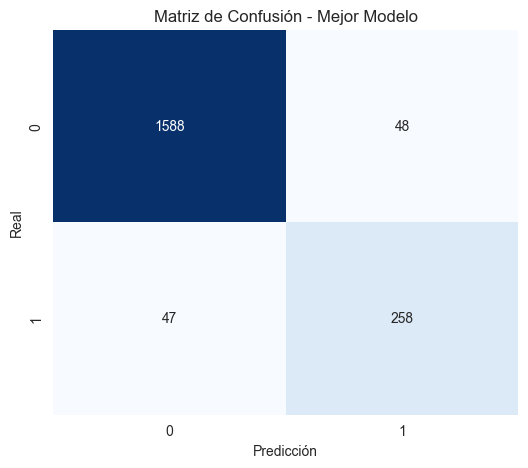

In [11]:
best_model = grid_search.best_estimator_

# Predicciones
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Métricas
print("📊 Reporte de Clasificación (Test Set):")
print(classification_report(y_test, y_pred))

auc_score = roc_auc_score(y_test, y_prob)
print(f"🚀 ROC-AUC Final en Test: {auc_score:.4f}")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Mejor Modelo')

# Guardar figura
FIGURES_PATH = OUTPUT_PATH / "figures"
FIGURES_PATH.mkdir(parents=True, exist_ok=True)
plt.savefig(FIGURES_PATH / "09_confusion_matrix_best_model.png", dpi=300, bbox_inches='tight')
print(f"📊 Gráfico guardado en: {FIGURES_PATH}/09_confusion_matrix_best_model.png")

plt.show()

---
## 6. Guardado del Modelo Final
Serializamos el modelo para uso futuro.

In [12]:
model_path = MODELS_PATH / "09_best_model.pkl"
joblib.dump(best_model, model_path)

print(f"💾 Modelo guardado exitosamente en: {model_path}")

💾 Modelo guardado exitosamente en: ../../outputs/gian/models/09_best_model.pkl
